In [1]:
import numpy as np

from tqdm import tqdm as progressbar

from matplotlib import pyplot as plt
from matplotlib import rc

rc('font', size=12)
rc('axes', titlesize=14)
rc('axes', labelsize=14)

%matplotlib inline
%config InlineBackend.figure_format='retina'

# CORE FUNCTIONS

In [2]:
def compute_mad(array, med):
    series_mad = np.abs(array - med)
    return np.median(series_mad)

def compute_mom(L):
    if len(L) < 10:
        L.sort()
        return L[int(len(L) / 2)]
    S = []
    l_index = 0

    for l_index in range(0, len(L) - 1, 5):
        S.append(L[l_index:l_index + 5])

    S.append(L[l_index:])
    Meds = []

    for sub_list in S:
        Meds.append(compute_mom(sub_list))

    L2 = compute_mom(Meds)
    L1 = L3 = []

    for i in L:
        if i < L2:
            L1.append(i)
        if i > L2:
            L3.append(i)

    if len(L) < len(L1):
        return compute_mom(L1)

    elif len(L) > len(L1) + 1:
        return compute_mom(L3)

    else:
        return L2

def downsample(array, downsampling):
    if downsampling == 0:
        return array

    series = []
    for i in range(0, len(array), downsampling):
        series.append(np.mean(array[i:i+downsampling]))
    return np.asarray(series)


def draw(n_samples=2500):
    return np.random.normal(0, 1, n_samples)

# SNR

In [3]:
def snr_median_mad(n_trials=1000, downsampling_levels=250, n_samples=2500):
    SNRs = np.zeros([downsampling_levels, n_trials])
    zeros = {}

    print ("Computing SNR [median and mad] - %s trials" % n_trials)
    for trial in progressbar(range(n_trials), ascii=True):
        distribution = draw(n_samples)
        for level in range(downsampling_levels):
            distribution = downsample(distribution, level)
            med = np.median(distribution)
            mad = compute_mad(distribution, med)
            if mad != 0:
                SNRs[level, trial] = (np.max(distribution) - med) / (mad * 1.48)
            else:
                SNRs[level, trial] = np.nan

    return SNRs, zeros


def snr_mom_mad(n_trials=1000, downsampling_levels=250, n_samples=2500):
    SNRs = np.zeros([downsampling_levels, n_trials])
    zeros = {}

    print("Computing SNR [mom and mad] - %s trials" % n_trials)
    for trial in progressbar(range(n_trials), ascii=True):
        distribution = draw(n_samples)
        for level in range(downsampling_levels):
            distribution = downsample(distribution, level)
            mom = compute_mom(distribution)
            mad = compute_mad(distribution, mom)

            if mad != 0:
                SNRs[level, trial] = (np.max(distribution) - mom) / (mad * 1.48)
            else:
                SNRs[level, trial] = np.nan
                
    return SNRs, zeros

# PLOT

In [4]:
def plot_trigger_ratio(SNRs_median, SNRs_mom, threshold=10, n_trials=1000, n_samples=2500, figure_name="trigger_ratio"):
    fig, ax = plt.subplots()

    labels = ['median+mad', 'mom+mad']
    colors = ['black', 'blue']
    marker = ['+', 'o']
    
    i = 0
    for SNRs in [SNRs_median, SNRs_mom]:
        first = True
        for level in range(SNRs.shape[0]):
            
            y = len(SNRs[level][np.where(SNRs[level] > threshold)]) / n_trials
                
            if level != 0:
                x = n_samples / level                
                if first:
                    ax.scatter(x,
                               y,
                               marker=marker[i],
                               color=colors[i],
                               label=labels[i],
                               )
                else: 
                    ax.scatter(x,
                               y,
                               marker=marker[i],
                               color=colors[i],
                               )
            else:
                x = n_samples
                if first:
                    ax.scatter(x,
                               y,
                               marker=marker[i],
                               color=colors[i],
                               label=labels[i],
                               )
                else: 
                    ax.scatter(x,
                               y,
                               marker=marker[i],
                               color=colors[i],
                               )
            ax.set_xlabel("N")
            ax.set_ylabel("Trigger fraction (SNR>" + str(threshold) + ")")
            first = False
        i += 1

    ax.set_yscale('log')
    ax.legend()
    filename = "%s_threshold_%s.pdf" % (figure_name, threshold)
    print ("Saving file %s" % filename)
    plt.tight_layout()
    plt.savefig(filename)

def plot_max_snr_per_downsampling_level(SNRs_median, SNRs_mom, n_samples=2500, figure_name="max_snr_per_downsampling"):
    fig, ax = plt.subplots()

    labels = ['median+mad', 'mom+mad']
    colors = ['black', 'blue']
    marker = ['+', 'o']
    
    i = 0
    for SNRs in [SNRs_median, SNRs_mom]:
        first = True
        for level in range(SNRs.shape[0]):
            
            y = np.nanmax(SNRs[level])
                
            if level != 0:
                x = n_samples / level
                if first:
                    ax.scatter(x,
                               y,
                               marker=marker[i],
                               color=colors[i],
                               label=labels[i],
                               )
                else:
                    ax.scatter(x,
                               y,
                               marker=marker[i],
                               color=colors[i],
                               )
            else:
                x = n_samples
                if first:
                    ax.scatter(x,
                               y,
                               marker=marker[i],
                               color=colors[i],
                               label=labels[i],
                               )
                else:
                    ax.scatter(x,
                               y,
                               marker=marker[i],
                               color=colors[i],
                               )
            first = False
            ax.set_xlabel("N")
            ax.set_ylabel("Max(SNR)")
        i+=1
        

    ax.set_yscale('log')
    ax.legend()
    filename = "%s.pdf" % (figure_name)
    print("Saving file %s" % filename)
    plt.tight_layout()
    plt.savefig(filename)

# MAIN

In [5]:
n_trials = 1000
downsampling_levels = 250
n_samples = 2500

SNR_median, zeros_median = snr_median_mad(n_trials, downsampling_levels, n_samples)
SNR_mom, zeros_mom = snr_mom_mad(n_trials, downsampling_levels, n_samples)

  0%|          | 3/1000 [00:00<00:45, 21.71it/s]

Computing SNR [median and mad] - 1000 trials


  0%|          | 3/1000 [00:00<00:38, 26.16it/s]

Computing SNR [mom and mad] - 1000 trials


100%|##########| 1000/1000 [00:38<00:00, 25.69it/s]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


Saving file trigger_ratio_threshold_10.pdf


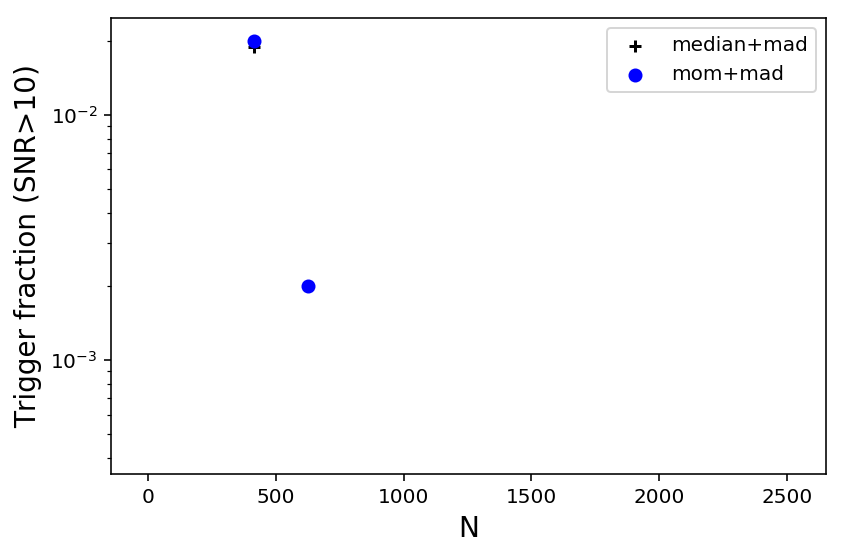

In [6]:
plot_trigger_ratio(SNR_median, SNR_mom, 10)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: All-NaN slice encountered


Saving file max_snr_per_downsampling.pdf


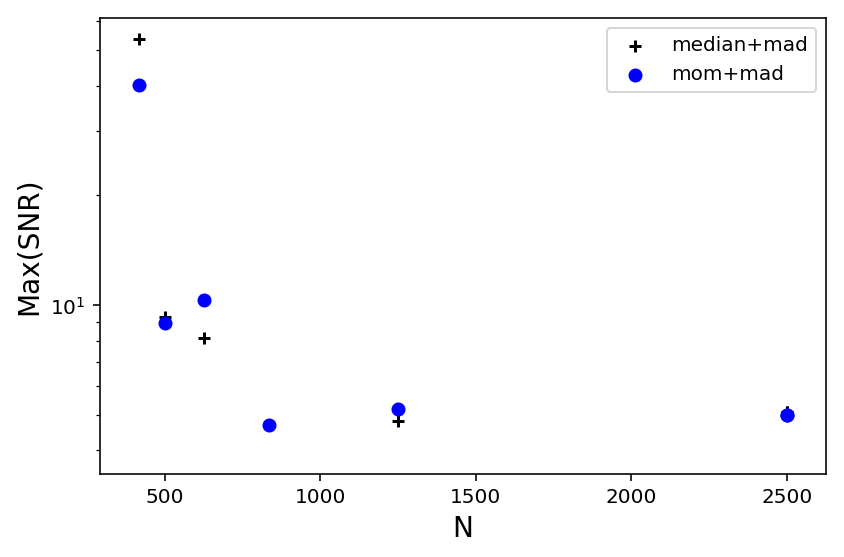

In [7]:
plot_max_snr_per_downsampling_level(SNR_median, SNR_mom)